## DATA301 Assignment 4
**Name:** Isabelle Southon

**Student ID:** 300597453

In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, make_scorer, balanced_accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate

### EDA

In [2]:
train = pd.read_csv("train.csv") # read in training set csv file
test = pd.read_csv("test.csv") # read in test set csv file

Drop 'customer_id' for both files as it does not provide useful information as it is just an identifier and may lead to overfitting.

In [3]:
train = train.drop("customer_id", axis=1) 
test = test.drop('customer_id', axis=1)

In [4]:
train.head() # check the first 5 observations of the dataset

year_of_observation  insured_period  residential building_painted  \
0                 2013             1.0            0                N   
1                 2015             1.0            0                V   
2                 2014             1.0            0                N   
3                 2013             1.0            0                V   
4                 2014             1.0            0                V   

  building_fenced garden settlement  building_dimension  building_type  \
0               V      V          U               290.0              1   
1               N      O          R               490.0              1   
2               V      V          U               595.0              1   
3               V      V          U              2840.0              1   
4               N      O          R               680.0              1   

   date_of_occupancy number_of_windows geo_code  claim  
0             1960.0                 .     1053      0  
1             1850.0                 4     1053      0  
2             1960.0                 .     1053      0  
3             1960.0                 .     1053      0  
4             1800.0                 3     1053      0

In [5]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_of_observation  6117 non-null   int64  
 1   insured_period       6117 non-null   float64
 2   residential          6117 non-null   int64  
 3   building_painted     6117 non-null   object 
 4   building_fenced      6117 non-null   object 
 5   garden               6110 non-null   object 
 6   settlement           6117 non-null   object 
 7   building_dimension   6015 non-null   float64
 8   building_type        6117 non-null   int64  
 9   date_of_occupancy    5658 non-null   float64
 10  number_of_windows    6117 non-null   object 
 11  geo_code             6019 non-null   object 
 12  claim                6117 non-null   int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 621.4+ KB


In [6]:
categorical_features = train.dtypes == 'object'
total_cat = categorical_features.sum()

numerical_features = (train.dtypes == 'int64') | (train.dtypes == 'float64')
total_num = numerical_features.sum()

print("Number of categorical features:", total_cat)
print("Number of numerical features:", total_num)
# claim is the target variable and has been stored as an integer 

Number of categorical features: 6
Number of numerical features: 7


In [7]:
train.shape #6117 instances, 13 features as we removed customer id

(6117, 13)

In [8]:
train.describe(include='all')

year_of_observation  insured_period  residential building_painted  \
count           6117.000000     6117.000000  6117.000000             6117   
unique                  NaN             NaN          NaN                2   
top                     NaN             NaN          NaN                V   
freq                    NaN             NaN          NaN             4566   
mean            2013.272192        0.906808     0.309956              NaN   
std                1.075760        0.243628     0.462513              NaN   
min             2012.000000        0.000000     0.000000              NaN   
25%             2012.000000        1.000000     0.000000              NaN   
50%             2013.000000        1.000000     0.000000              NaN   
75%             2014.000000        1.000000     1.000000              NaN   
max             2015.000000        1.000000     1.000000              NaN   

       building_fenced garden settlement  building_dimension  building_type  \
count             6117   6110       6117         6015.000000    6117.000000   
unique               2      2          2                 NaN            NaN   
top                  V      V          U                 NaN            NaN   
freq              3137   3136       3135                 NaN            NaN   
mean               NaN    NaN        NaN         1879.536326       2.190289   
std                NaN    NaN        NaN         2268.133418       0.938294   
min                NaN    NaN        NaN            1.000000       1.000000   
25%                NaN    NaN        NaN          520.000000       2.000000   
50%                NaN    NaN        NaN         1084.000000       2.000000   
75%                NaN    NaN        NaN         2288.500000       3.000000   
max                NaN    NaN        NaN        20940.000000       4.000000   

        date_of_occupancy number_of_windows geo_code        claim  
count         5658.000000              6117     6019  6117.000000  
unique                NaN                11     1216          NaN  
top                   NaN                 .     6088          NaN  
freq                  NaN              3136      122          NaN  
mean          1964.894662               NaN      NaN     0.231976  
std             35.118585               NaN      NaN     0.422129  
min           1545.000000               NaN      NaN     0.000000  
25%           1960.000000               NaN      NaN     0.000000  
50%           1970.000000               NaN      NaN     0.000000  
75%           1980.000000               NaN      NaN     0.000000  
max           2015.000000               NaN      NaN     1.000000

Replace NaN and '   .' values in the number_of_windows column and convert it from an object to numeric. 

In [9]:
train['number_of_windows'] = pd.to_numeric(train['number_of_windows'], errors='coerce')
test['number_of_windows'] = pd.to_numeric(test['number_of_windows'], errors='coerce')

In [10]:
corr_matrix = train.corr() # .corr() is Pearsons correlation
corr_matrix["claim"].sort_values(ascending=False)

claim                  1.000000
building_dimension     0.298694
number_of_windows      0.228580
building_type          0.107735
insured_period         0.089251
residential            0.061279
date_of_occupancy      0.022579
year_of_observation   -0.001887
Name: claim, dtype: float64

The top three correlated features with 'claim' are 'building_dimension' (moderate correlation), 'number_of_windows' (moderate correlation), and 'building_type' (weak correlation). They are all positive correlations. This suggests that over the specified period, the size of the building (in $m^2$) and the number of windows in a building are related to whether the building will file an insurance claim or not. 

It is important to note here that a lot of these variables have been inputted as numerical variables, however, by nature they should be categorical. For example, 'insured_period', 'residential', 'date_of_occupancy', and 'year_of_observation', are all categorical naturally, but have been inputted into this dataset as numerical variables.

In [11]:
train.isnull().sum()

year_of_observation       0
insured_period            0
residential               0
building_painted          0
building_fenced           0
garden                    7
settlement                0
building_dimension      102
building_type             0
date_of_occupancy       459
number_of_windows      3191
geo_code                 98
claim                     0
dtype: int64

The variables 'garden', 'building_dimension', 'date_of_occupancy', and 'geo_code' have missing data. 

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_of_observation  6117 non-null   int64  
 1   insured_period       6117 non-null   float64
 2   residential          6117 non-null   int64  
 3   building_painted     6117 non-null   object 
 4   building_fenced      6117 non-null   object 
 5   garden               6110 non-null   object 
 6   settlement           6117 non-null   object 
 7   building_dimension   6015 non-null   float64
 8   building_type        6117 non-null   int64  
 9   date_of_occupancy    5658 non-null   float64
 10  number_of_windows    2926 non-null   float64
 11  geo_code             6019 non-null   object 
 12  claim                6117 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 621.4+ KB


**Numeric variables:**
* year_of_observation 
* insured_period      
* residential           
* building_dimension  
* building_type      
* date_of_occupancy   
* number_of_windows  

**Categorical variables:**
* building_painted     
* building_fenced      
* garden              
* settlement          
* geo_code  

0    4698
1    1419
Name: claim, dtype: int64
0    0.768024
1    0.231976
Name: claim, dtype: float64


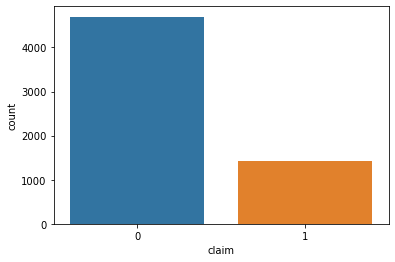

In [13]:
print(train['claim'].value_counts()) 
print(train['claim'].value_counts() / len(train))
sns.countplot(x = train['claim']);

The classes are imbalanced as seen above. There are more instances with no claim (class 0) than at least one claim over an insured period (class 1).

In [14]:
train.corr()

year_of_observation  insured_period  residential  \
year_of_observation             1.000000        0.006986    -0.035845   
insured_period                  0.006986        1.000000    -0.030979   
residential                    -0.035845       -0.030979     1.000000   
building_dimension              0.009163        0.013249     0.059707   
building_type                   0.019790       -0.022554     0.338037   
date_of_occupancy              -0.014259       -0.010581    -0.035468   
number_of_windows              -0.003948       -0.006489     0.193308   
claim                          -0.001887        0.089251     0.061279   

                     building_dimension  building_type  date_of_occupancy  \
year_of_observation            0.009163       0.019790          -0.014259   
insured_period                 0.013249      -0.022554          -0.010581   
residential                    0.059707       0.338037          -0.035468   
building_dimension             1.000000       0.013569           0.208821   
building_type                  0.013569       1.000000          -0.145513   
date_of_occupancy              0.208821      -0.145513           1.000000   
number_of_windows              0.377314       0.307122          -0.038107   
claim                          0.298694       0.107735           0.022579   

                     number_of_windows     claim  
year_of_observation          -0.003948 -0.001887  
insured_period               -0.006489  0.089251  
residential                   0.193308  0.061279  
building_dimension            0.377314  0.298694  
building_type                 0.307122  0.107735  
date_of_occupancy            -0.038107  0.022579  
number_of_windows             1.000000  0.228580  
claim                         0.228580  1.000000

Above is a correlation matrix displaying how well each feature is correlated with one another. However, it does not give much useful information as many variables are meant to be categorical rather than numerical. 

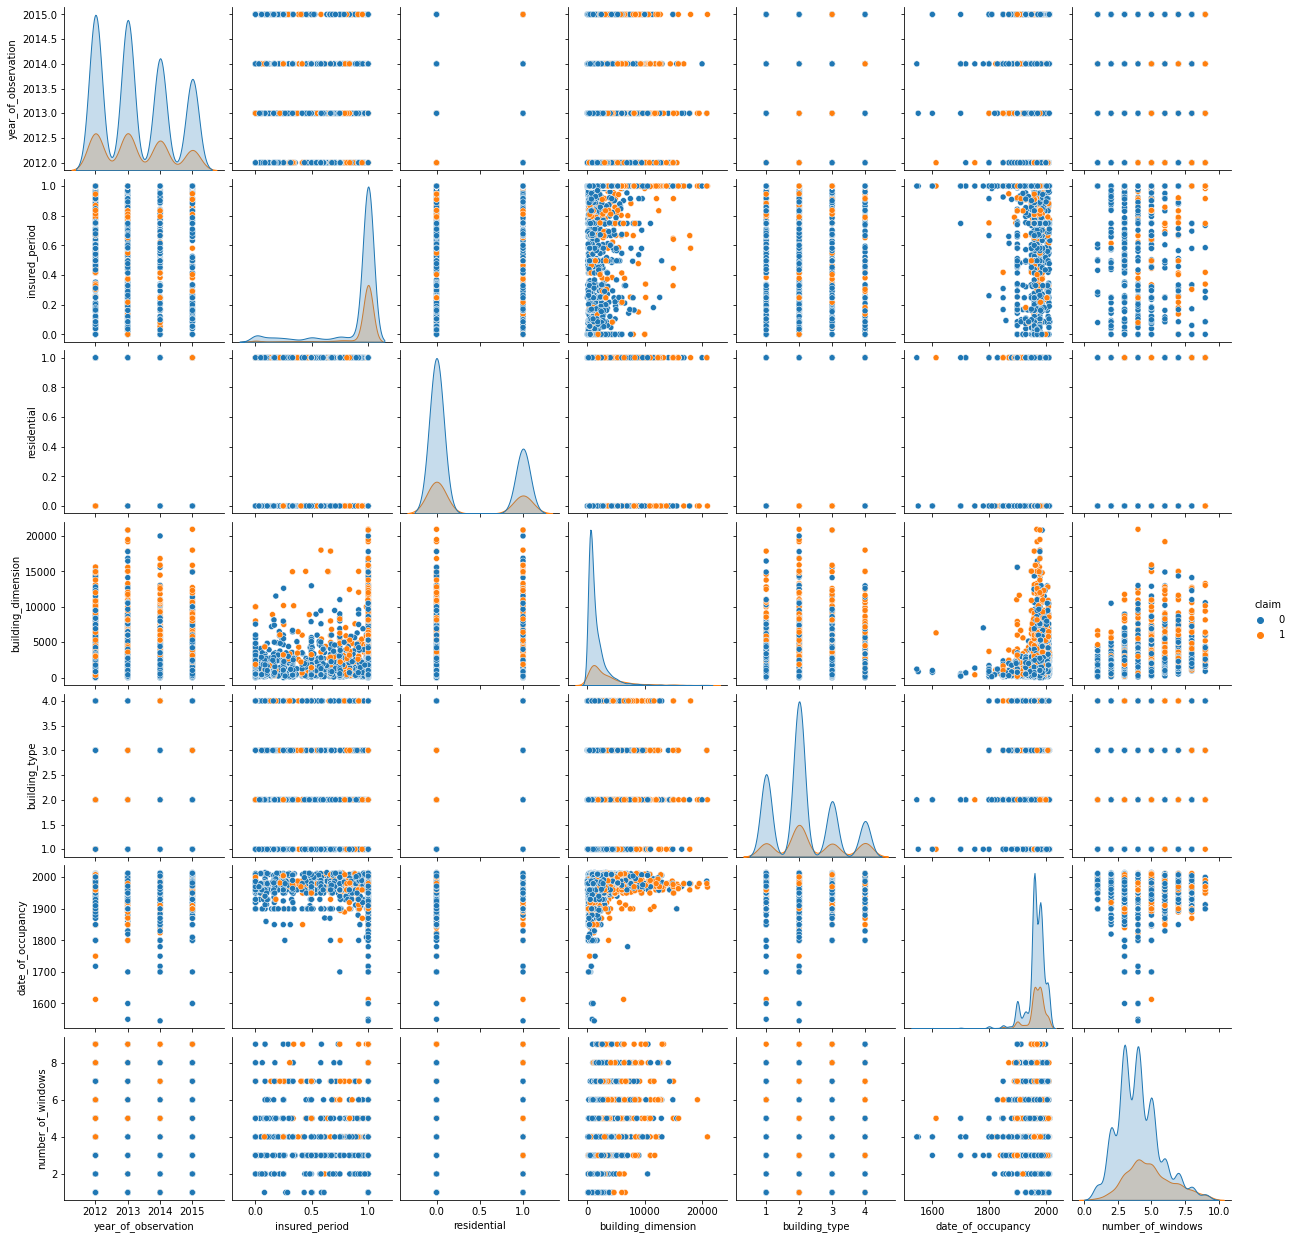

In [15]:
sns.pairplot(train,hue="claim")

### What can we conclude from the pair plot above? 
* In every year, there are more no claims (class 0) than there are at least one claim (class 1).
* The date the building was first occuppied appears to be positively correlated with the size of the insured building in $m^2$. 
* There sort of looks to be no clear relationship between features and our target variable claim (0 or 1). 

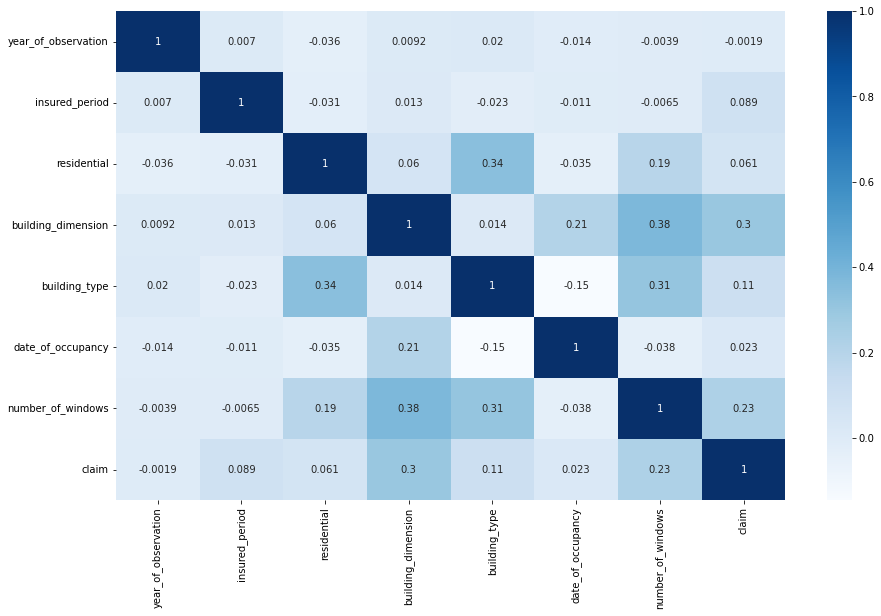

In [16]:
fig = plt.figure(figsize = (15,9))
sns.heatmap(train.corr(), cmap='Blues', annot = True);

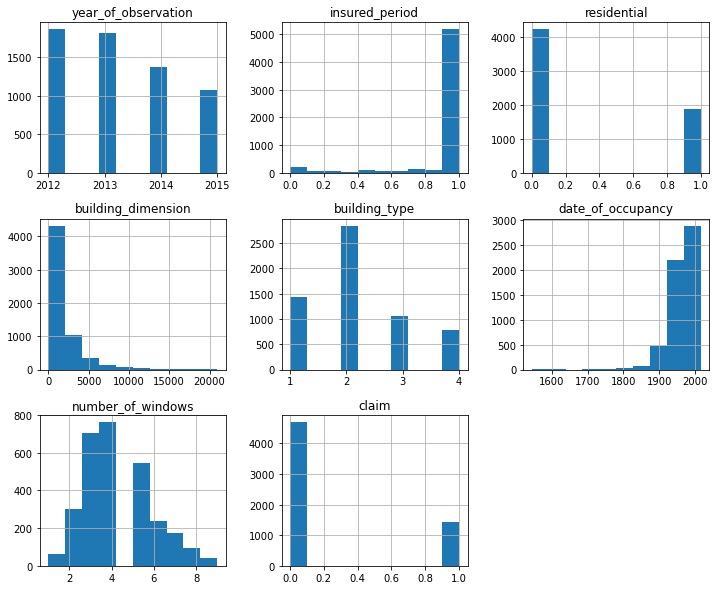

In [17]:
train.hist(figsize=(12, 10)) # using histograms to see the distribution of 'numerical' features.  
plt.show()

Assuming 0 is no and 1 is yes
### What can we conclude from the histograms above? 
* The distributions are non-normal because features have been inputted incorrectly.
* We can see that the number of observations decreases as time goes on (there are more observations in 2012 than there are 2015).
* More buildings had full year insurance than they did any other time period (e.g. 6 months).
* More buildings are not residential.
* The building dimension in $m^2$ is right skewed. 
* There are more buildings that are type 2 than any other type. 
* More buildings are occuppied in later years. 
* There tend to be more buildings with 3, 4, and 6 windows.
* The target variable (claim) is unbalanced as there are more buildings with no claim than at least one claim. 

Looking at the value counts for categorical variables

In [18]:
train['building_painted'].value_counts()

V    4566
N    1551
Name: building_painted, dtype: int64

In [19]:
train['building_fenced'].value_counts()

V    3137
N    2980
Name: building_fenced, dtype: int64

In [20]:
train['garden'].value_counts()

V    3136
O    2974
Name: garden, dtype: int64

In [21]:
train['settlement'].value_counts()

U    3135
R    2982
Name: settlement, dtype: int64

In [22]:
train['geo_code'].value_counts()

6088     122
33063    121
6083      92
13206     85
31555     78
        ... 
57433      1
57606      1
57751      1
57757      1
2B353      1
Name: geo_code, Length: 1216, dtype: int64

### PREPARE DATA FOR ML ALGORITHMS

In [23]:
# drop the labels for the training and test set
X_train = train.drop('claim', axis=1)
y_train = train['claim'].copy()
X_test = test.drop('claim', axis=1)
y_test = test['claim'].copy()

In [24]:
X_train.head()

year_of_observation  insured_period  residential building_painted  \
0                 2013             1.0            0                N   
1                 2015             1.0            0                V   
2                 2014             1.0            0                N   
3                 2013             1.0            0                V   
4                 2014             1.0            0                V   

  building_fenced garden settlement  building_dimension  building_type  \
0               V      V          U               290.0              1   
1               N      O          R               490.0              1   
2               V      V          U               595.0              1   
3               V      V          U              2840.0              1   
4               N      O          R               680.0              1   

   date_of_occupancy  number_of_windows geo_code  
0             1960.0                NaN     1053  
1             1850.0                4.0     1053  
2             1960.0                NaN     1053  
3             1960.0                NaN     1053  
4             1800.0                3.0     1053

In [25]:
X_train.dtypes

year_of_observation      int64
insured_period         float64
residential              int64
building_painted        object
building_fenced         object
garden                  object
settlement              object
building_dimension     float64
building_type            int64
date_of_occupancy      float64
number_of_windows      float64
geo_code                object
dtype: object

The features 'residential' and 'building_type' have been encoded already. The 'year_of_observation' is an integer already which is suitable. The remaining variables need to be preprocessed using different pipelines (categorical and numerical) so models can handle data appropriately. 

In [26]:
numerical_columns = ["insured_period", 
                     "building_dimension", 
                     "date_of_occupancy", 
                     "number_of_windows"]

categorical_columns = ["building_painted",
                       "building_fenced",
                       "garden",
                       "settlement",
                       "number_of_windows",
                       "geo_code"]

### FIRST PIPELINE
* Preprocess the data: impute missing values, scale numeric data, encoding

In [27]:
# Create the numeric and categorical pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))  
])

In [28]:
preprocessor_v1 = ColumnTransformer([
    ('numerical_preprocessor', num_pipeline, numerical_columns),
    ('categorical_preprocessor', cat_pipeline, categorical_columns),
])

### BASELINE MODEL

* Random Forest Classifier

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

rf_model = Pipeline([
    ('preprocessor', preprocessor_v1),
    ('classifier', RandomForestClassifier(random_state=0))
])

rf_model.fit(X_train, y_train);

y_pred_proba = cross_val_predict(rf_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'Mean 5-fold Cross Validation AUC-ROC Score: {roc_auc:.4f}')

Mean 5-fold Cross Validation AUC-ROC Score: 0.6427


### SECOND PIPELINE
* Preprocess the data: impute missing values, encoding 
* Remove StandardScaler( ), which simplifies the preprocessor
* Optimize model by implementing SMOTE, utilising random undersampling of the majority class - this accounts for the imbalance in the target variable 'claim'

In [30]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

num_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor_v2 = ColumnTransformer([
    ('numerical_preprocessor2', num_pipeline2, numerical_columns),
    ('categorical_preprocessor', cat_pipeline, categorical_columns)
])

rf_model2 = ImbPipeline([
    ('preprocessor_v2', preprocessor_v2),
    ('smote', SMOTE(random_state=0)), 
    ('undersample', RandomUnderSampler(random_state=0)), 
    ('classifier', RandomForestClassifier(random_state=0))
])

### IMPROVED MODEL
* Random Forest Classifier 

In [31]:
rf_model2.fit(X_train, y_train);

y_pred_proba = cross_val_predict(rf_model2, X_train, y_train, cv=5, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'Mean 5-fold Cross Validation AUC-ROC Score: {roc_auc:.4f}')

Mean 5-fold Cross Validation AUC-ROC Score: 0.6452


As evident, the mean 5-fold CV AUC-ROC training score for the baseline model is 0.6427. When the scaling of numeric features is removed, and SMOTE is implemented, the mean 5-fold CV AUC-ROC training score for the improved model is 0.6452. To see if I can further improve the model, I will perform hyperparameter tuning and feature selection. 

### HYPERPARAMETER TUNING 

In [32]:
from scipy.stats import randint

rf_2_grid = {
    'classifier__n_estimators': randint(50, 200), 
    'classifier__max_features': randint(3, 11),
    'classifier__max_depth': randint(5, 100),
    'classifier__min_samples_leaf': randint(2, 4),
}

In [33]:
from sklearn.model_selection import RandomizedSearchCV

rf_model_2_grid_cv = RandomizedSearchCV(
    rf_model2,
    rf_2_grid,
    n_iter=5,
    cv=5,
    scoring='roc_auc',
    return_train_score=True,
    random_state=0
)

In [34]:
rf_model_2_grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor_v2',
                                              ColumnTransformer(transformers=[('numerical_preprocessor2',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['insured_period',
                                                                                'building_dimension',
                                                                                'date_of_occupancy',
                                                                                'number_of_windows']),
                                                                              ('categorical_preprocessor',
                                                     

In [35]:
rf_model_2_grid_cv.best_params_

{'classifier__max_depth': 41,
 'classifier__max_features': 10,
 'classifier__min_samples_leaf': 2,
 'classifier__n_estimators': 138}

In [36]:
y_pred_proba = cross_val_predict(rf_model_2_grid_cv, X_train, y_train, cv=5, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'Mean 5-fold Cross Validation AUC-ROC Score: {roc_auc:.4f}')

Mean 5-fold Cross Validation AUC-ROC Score: 0.6319


After hyperparameter tuning using randomized search cv, performance decreases from approximately 0.6452 to 0.6319. There are a lot of features training the random forest, therefore it might be becoming too complex leading to the decrease in performance. Hyperparameter tuning typically enhances performance. 

### FEATURE SELECTION USING FEATURE IMPORTANCE

In [37]:
rf_best = rf_model_2_grid_cv.best_estimator_

preprocessor = rf_best.named_steps['preprocessor_v2']

cat_feature_names = preprocessor.named_transformers_['categorical_preprocessor'].named_steps['onehot'].get_feature_names_out(categorical_columns)

num_feature_names = numerical_columns

feature_names = list(num_feature_names) + list(cat_feature_names)

feature_importances = rf_best.named_steps['classifier'].feature_importances_

# create df of important features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [38]:
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False) 
top_10 = importance_df_sorted.head(10)  

print(top_10)

               Feature  Importance
1   building_dimension    0.086235
3    number_of_windows    0.060274
9             garden_V    0.057495
7    building_fenced_V    0.053810
6    building_fenced_N    0.051091
8             garden_O    0.050709
10        settlement_R    0.046395
5   building_painted_V    0.044662
11        settlement_U    0.037803
4   building_painted_N    0.033203


* Important features: building_dimension, number_of_windows, building_fenced, garden, settlement, building_painted

* Unimportant features: year_of_observation, insured_period, residential, building_type, date_of_occupancy, geo_code

The unimportant features will be removed before training and testing on the test set. 

In [39]:
important_features = X_train[['building_dimension',
                              'number_of_windows',
                              'building_fenced',
                              'garden', 
                              'settlement',
                              'building_painted']]

In [40]:
important_features.dtypes

building_dimension    float64
number_of_windows     float64
building_fenced        object
garden                 object
settlement             object
building_painted       object
dtype: object

In [41]:
important_numerical_columns = important_features.columns[important_features.dtypes == 'float64'].tolist()

important_categorical_columns = important_features.columns[important_features.dtypes == 'object'].tolist()

In [42]:
numerical_pipeline_reduced = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline_reduced = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [43]:
preprocessor_reduced = ColumnTransformer([
    ('numerical_preprocessor', numerical_pipeline_reduced, important_numerical_columns),
    ('categorical_preprocessor', categorical_pipeline_reduced, important_categorical_columns)
])

rf_model3 = ImbPipeline([
    ('preprocessor_reduced', preprocessor_reduced),
    ('smote', SMOTE(random_state=0)),  
    ('undersample', RandomUnderSampler(random_state=0)),  
    ('classifier', RandomForestClassifier(random_state=0))
])

In [44]:
rf_3_grid = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_features': randint(3, 11),
    'classifier__max_depth': randint(5, 100),
    'classifier__min_samples_leaf': randint(2, 4),
}

In [45]:
rf_model_3_grid_cv = RandomizedSearchCV(
    rf_model3,
    rf_3_grid,
    n_iter=5,
    cv=5,
    scoring='roc_auc',
    return_train_score=True,
    random_state=0
)

rf_model_3_grid_cv.fit(important_features, y_train)

best_params = rf_model_3_grid_cv.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'classifier__max_depth': 17, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 89}


In [46]:
y_pred_proba = cross_val_predict(rf_model_3_grid_cv, important_features, y_train, cv=5, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'Mean 5-fold Cross Validation AUC-ROC Score: {roc_auc:.4f}')

Mean 5-fold Cross Validation AUC-ROC Score: 0.6384


We find that the best model was my improved model that implemented SMOTE and removed the scaling of numerical variables. The random forest classifier does not perform better on the training set when removing features or performing hyperparameter tuning. When removing unimportant features, the performance of the random forest classifier decreases from 0.6452 to 0.6384. This indicates that some of the original features are contributing important information for the model, but were not deemed important by the 'feature_importance_' function. This means that some of the original features could provide useful information for the models ability to classify between buildings that have made at least one insurance claim or not over the insured duration period.

### TESTING ON THE TEST DATA

The baseline model (random forest model) and optimized model (random forest model with SMOTE implemented and no scaling of numeric variables) will be evaluated on the test set to assess which model performs better on new, unseen data. 

In [47]:
scoring = {
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': 'average_precision',
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1'
}

results = {}

In [48]:
baseline = rf_model
optimized = rf_model2

models = {
    'Original Random Forest': baseline,
    'Optimized Random Forest': optimized
}

In [49]:
y_pred_proba_baseline = cross_val_predict(baseline, X_test, y_test, cv=5, method='predict_proba')[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_baseline)
test_scores = cross_validate(baseline, X_test, y_test, cv=5, scoring=scoring)
results[baseline] = {
        'Mean AUC-ROC': np.mean(test_scores['test_roc_auc']),
        'Mean AUC-PR': np.mean(test_scores['test_average_precision']),
        'Mean Balanced Accuracy': np.mean(test_scores['test_balanced_accuracy']),
        'Mean F1 Score': np.mean(test_scores['test_f1'])
}

In [50]:
y_pred_proba_optimized = cross_val_predict(optimized, X_test, y_test, cv=5, method='predict_proba')[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
test_scores = cross_validate(optimized, X_test, y_test, cv=5, scoring=scoring)
results[optimized] = {
    'Mean AUC-ROC': np.mean(test_scores['test_roc_auc']),
    'Mean AUC-PR': np.mean(test_scores['test_average_precision']),
    'Mean Balanced Accuracy': np.mean(test_scores['test_balanced_accuracy']),
    'Mean F1 Score': np.mean(test_scores['test_f1'])
}

In [51]:
print("Baseline Random Forest:")
results[baseline]

Baseline Random Forest:


{'Mean AUC-ROC': 0.5297903665401564,
 'Mean AUC-PR': 0.32270209301185526,
 'Mean Balanced Accuracy': 0.5297903665401563,
 'Mean F1 Score': 0.14091063030529816}

In [52]:
print("Optimized Random Forest:")
results[optimized]

Optimized Random Forest:


{'Mean AUC-ROC': 0.534678502593885,
 'Mean AUC-PR': 0.3306715055572389,
 'Mean Balanced Accuracy': 0.534678502593885,
 'Mean F1 Score': 0.1742697242531574}

The optimized random forest classifier outperforms the original random forest classifier for all metrics. This indicates that: 

* **AUC-ROC:** The optimized model slightly outperforms the baseline random forest model. This means that the optimized model is able to better distinguish between positive and negative classes and correctly classify instances to both classes. 


* **AUC-PR:** The AUC-PR improved from 0.3227 to 0.3307, suggesting a slight improvement in the models precision-recall balance. This means the optimized model is marginally better at identifying the positive class while keeping false positives lower. 


* **Balanced Accuracy:** Balanced accuracy improves for the optimized model. This indicates that there is a slight improvement in the ability to classify both the minority and majority classes equally well.


* **F1 Score:** The F1 score displays a more noticeable improvement from 0.1409 to 0.1743. Despite this improvement being quite small, it shows that the optimized model is a little better at balancing precision and recall. This means that there are fewer false positives and false negatives with the optimized model in comparison to the original random forest model. 

### PLOT COMPARING BASELINE MODEL AND OPTIMIZED MODEL

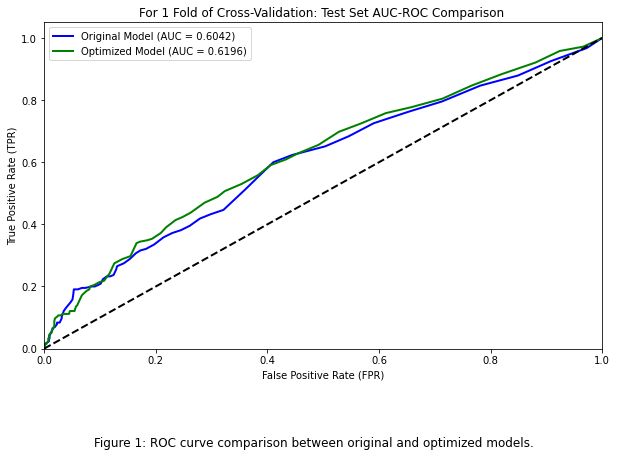

In [53]:
fpr_original, tpr_original, _ = roc_curve(y_test, y_pred_proba_baseline)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

plt.figure(figsize=(10, 6))
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label=f'Original Model (AUC = {roc_auc_original:.4f})')
plt.plot(fpr_optimized, tpr_optimized, color='green', lw=2, label=f'Optimized Model (AUC = {roc_auc_optimized:.4f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('For 1 Fold of Cross-Validation: Test Set AUC-ROC Comparison ')
plt.legend()
plt.figtext(0.5, -0.1, 'Figure 1: ROC curve comparison between original and optimized models.', 
            ha='center', fontsize=12)
plt.show()

### DISCUSSION

I have learnt a lot when completing this assignment. I learnt that hyperparameter tuning does not always lead to a better performing model. This might be due to the imbalance of classes for the target variable 'claim', where in the training set approximately 76.80% of instances belong to class 0, and approximately 23.18% belong to class 1. 

As a result, I found that implementing SMOTE and random undersampling helped with the class imbalance and obtaining a better AUC-ROC score on the training set. Had I not used SMOTE in my optimised model, my model might not have performed well on test data. What also worked was using evaluation metrics that were robust to imbalances in the target variable.

I am suspicious of my results obtained from using the 'feature_importance_' function, because when I removed unimportant features then used SMOTE, removed the scaling of numerical features, and performed hyperparameter tuning, my random forest model did not improve. This might have been because tree-based models are somewhat robust to having lots of features because they can automatically choose the most important ones. Instead, valuable information might have been removed when I reduced the number of features, thus meaning performance on the training set did not improve. Underfitting might have been caused as a result of removing features led to a model that was too simple to capture underlying patterns in the data. 

Lastly, if I had more time, I would try a variety of models such as a decision tree classifier or logistic regression model to see if they could better predict whether a building will file an insurance claim or not. These models might potentially generalise better to new, unseen data (test data) than my optimized random forest classifier did. 